<a href="https://colab.research.google.com/github/turagsarkar/Machine-learning/blob/main/Image_Based_Plant_leaf_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***`Using deep transfer learning approch for Image-Based Plant leaf Disease Detection model based on computer vision`***

***Dataset collection from***
[https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/data](https://)


In [1]:
#collcting data from google drive
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
#libaray import
import keras
import numpy as np
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Activation, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [3]:
#Load data using a Keras utility
batch_size = 24
img_height = 256
img_width = 256
data_dir='/content/drive/MyDrive/leaf/Train/Train'

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1322 files belonging to 3 classes.
Using 1058 files for training.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Healthy', 'Powdery', 'Rust']


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1322 files belonging to 3 classes.
Using 264 files for validation.


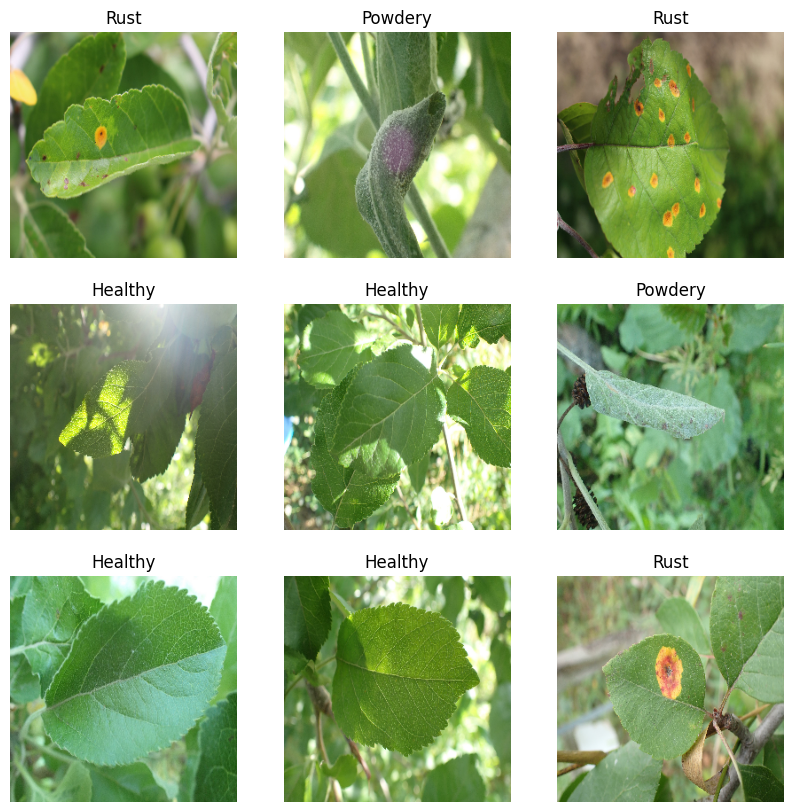

In [7]:
#Data Exploration and Visualisation
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(24, 256, 256, 3)
(24,)


In [9]:
data='/content/drive/MyDrive/leaf/Test/Test'

In [10]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data,
  seed=123,
  image_size=(img_height, img_width),
  validation_split = 0,
  batch_size=batch_size)

Found 150 files belonging to 3 classes.


In [11]:
print('\nTraining Dataset:', train_ds)
print('\nTesting Dataset:', test_ds)
print('\nValidation Dataset:', val_ds)


Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Testing Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [12]:
# Checking minimum and maximum pixel values in the train dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in train_ds:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 255.0


In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [15]:
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [16]:
# Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in val_ds:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 1.0


In [17]:
#data augmentation
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
        factor = (-.25, .3),
        fill_mode = 'reflect',
        interpolation = 'bilinear',
        seed = 123),


        tf.keras.layers.RandomBrightness(
        factor = (-.45, .45),
        value_range = (0.0, 1.0),
        seed = 123),

        tf.keras.layers.RandomContrast(
        factor = (.5),
        seed = 123)
    ]
)

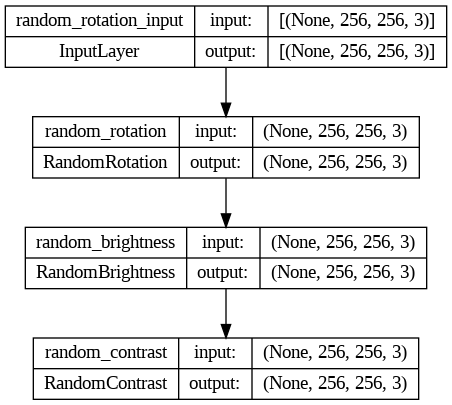

In [18]:
augmentation.build((None, 256, 256, 3)) # Building model
# Plotting model
tf.keras.utils.plot_model(augmentation,
                          show_shapes = True,
                          show_layer_names = True,
                          expand_nested = True)

In [19]:
from keras import Sequential

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
model = Sequential()

model.add(augmentation) # Adding data augmentation pipeline to the model

    # Feature Learning Layers
model.add(Conv2D(32,                  # Number of filters/Kernels
                     (3,3),               # Size of kernels (3x3 matrix)
                     strides = 1,         # Step size for sliding the kernel across the input (1 pixel at a time).
                     padding = 'same',    # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input.
                    input_shape = (256,256,3) # Input image shape
                    ))
model.add(Activation('relu'))# Activation function
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5,5), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv2D(256, (5,5), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

    # Flattening tensors
model.add(Flatten())

    # Fully-Connected Layers
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.5))

    # Output Layer
model.add(Dense(3, activation = 'softmax'))

In [22]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), # 1e-4
              loss = 'categorical_crossentropy', # Ideal for multiclass tasks
              metrics = ['accuracy']) # Evaluation metric

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('model_new.h5',
                            monitor = 'val_accuracy',
                            save_best_only = True)

In [24]:
try:
    history = model.fit(
        train_ds, epochs = 10,
        validation_data = test_ds,
        callbacks = [early_stopping, checkpoint])
except Exception as e:
    print("An error occurred:", e)

Epoch 1/10
An error occurred: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, samp

In [25]:
IMAGE_SIZE = [224, 224]

In [26]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [27]:
for layer in inception.layers:
    layer.trainable = False

In [28]:
x = Flatten()(inception.output)
prediction = Dense(3, activation='softmax')(x)

# create a model object
conv_base = Model(inputs=inception.input, outputs=prediction)

In [29]:
conv_base.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_5 (Bat  (None, 111, 111, 32)         96        ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_6 (Activation)   (None, 111, 111, 32)         0         ['batch_normalization_5[0]

In [30]:
from keras import Sequential
model = Sequential()
model.add(augmentation)
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [31]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [32]:
history = model.fit(train_ds,epochs=10,validation_data=val_ds)

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 256, 256, 3)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)
      • training=True
      • mask=None


In [ ]:
from keras.applications.vgg16 import VGG16
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

In [ ]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

In [ ]:
conv_base.summary()

In [ ]:
from keras import Sequential
model = Sequential()
model.add(augmentation)
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(lr=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
history = model.fit(train_ds,epochs=10,validation_data=val_ds)

In [ ]:
uhui import

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

In [ ]:
from keras.models import Sequential

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
IMAGE_SIZE = [256, 256]

In [ ]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(inception.output)

In [ ]:
folders=train_ds

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
model.summary()

In [ ]:
 model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)